In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne

import os

In [3]:
df = pd.read_csv('Data/7152018_kelly_csv_3_raw.csv', comment='#')

In [4]:
df.columns

Index([u'Time', u'P3', u'C3', u'F3', u'Fz', u'F4', u'C4', u'P4', u'Cz', u'CM',
       u'A1', u'Fp1', u'Fp2', u'T3', u'T5', u'O1', u'O2', u'X3', u'X2', u'F7',
       u'F8', u'X1', u'A2', u'T6', u'T4', u'Trigger', u'Time_Offset',
       u'ADC_Status', u'ADC_Sequence', u'Event', u'Comments'],
      dtype='object')

In [5]:
electrode_col_names = [u'P3', u'C3', u'F3', u'Fz', u'F4', u'C4', u'P4', u'Cz', u'CM',
       u'A1', u'Fp1', u'Fp2', u'T3', u'T5', u'O1', u'O2', u'X3', u'X2', u'F7',
       u'F8', u'X1', u'A2', u'T6', u'T4']

In [6]:
for electrode_col_name in electrode_col_names:
    df['d' + electrode_col_name + '-A1'] = df[electrode_col_name] - df['A1']

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [12]:
d_electrode_col_names = ['d' + electrode_col_name + '-A1' for electrode_col_name in electrode_col_names]

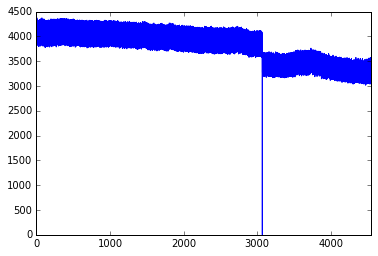

In [8]:
df['dCz-A1'].plot()

In [21]:
from numpy.fft import fft, fftshift
import scipy.signal

In [64]:
data_dict = {'time' : [], 'electrode' : [], 'frequency' : [], 'power' : []}
# for col_name in d_electrode_col_names:
#     if col != 'dA1-A1':
#         for frequency_hz in range(30):
#             data_dict[col_name + '_' + str(frequency_hz) + 'Hz'] = []

for index, row in df.iterrows():
    # Grab out trailing 1second window, i.e. 300 samples since we are sampling at 300Hz.
    if index <= 300:
        continue
    
    time = row['Time']
    
    if index % 100 == 0:
        window_starting_index = index - 300
        window = df[(df.index > window_starting_index) & (df.index <= index)]

        for col in d_electrode_col_names:
            if col != 'dA1-A1':
                
                window_col = [float(x) for x in window[col].values]
                f, Pxx_den = scipy.signal.periodogram(window_col, 300)
                
                power_by_bands = {}
                power_by_bands['theta'] = sum([Pxx_den[frequency_hz] for frequency_hz in range(4,8)])
                power_by_bands['alpha'] = sum([Pxx_den[frequency_hz] for frequency_hz in range(8,16)])
                power_by_bands['beta'] = sum([Pxx_den[frequency_hz] for frequency_hz in range(16,32)])
                power_by_bands['gamma'] = sum([Pxx_den[frequency_hz] for frequency_hz in range(32,64)])
                
                for frequency_band in ['theta', 'alpha', 'beta', 'gamma']:
                    data_dict['time'].append(time)
                    data_dict['electrode'].append(col)
                    data_dict['frequency'].append(frequency_band)
                    data_dict['power'].append(power_by_bands[frequency_band])
                    
#             plt.semilogy(f, Pxx_den)
#     #         plt.ylim([1e-7, 1e2])
#             plt.xlabel('frequency [Hz]')
#             plt.ylabel('PSD [V**2/Hz]')
#             plt.savefig('figs/' + col + '_' + str(index) + '.png')
#             plt.close('all')

In [69]:
data_df = pd.DataFrame(data_dict)
data_df = data_df[data_df['time'] <= 10]
data_df = data_df.set_index(['time','electrode','frequency'])

In [70]:
import xarray as xr
dataset = xr.Dataset.from_dataframe(data_df)

In [72]:
dataset.electrode.values

array([u'dA2-A1', u'dC3-A1', u'dC4-A1', u'dCM-A1', u'dCz-A1', u'dF3-A1',
       u'dF4-A1', u'dF7-A1', u'dF8-A1', u'dFp1-A1', u'dFp2-A1', u'dFz-A1',
       u'dO1-A1', u'dO2-A1', u'dP3-A1', u'dP4-A1', u'dT3-A1', u'dT4-A1',
       u'dT5-A1', u'dT6-A1', u'dX1-A1', u'dX2-A1', u'dX3-A1'],
      dtype=object)

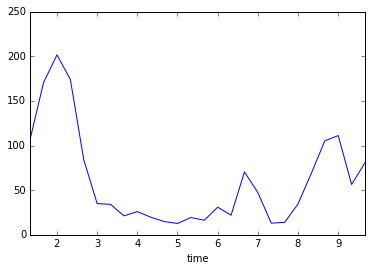

In [77]:
dataset.sel(electrode='dP3-A1',frequency='theta').to_dataframe()['power'].plot()